In [1]:
import random
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle
import skimage


In [2]:
import os
import cv2
import time
import numpy as np
from mrcnn.config import Config
from mrcnn.model import MaskRCNN
from mrcnn.model import mold_image


class_category_list = ['router', 'ceiling fan', 'tv', 'laptop']


# define the prediction configuration
class PredictionConfig(Config):
    # define the name of the configuration
    NAME = "multiclass_cfg"
    # Number of classes (background + other classes)
    NUM_CLASSES = 1 + len(class_category_list)
    # simplify GPU config
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1


class DeviceDetectionMulticlass:

    def __init__(self, model_folder, model_name):

        self.cfg = PredictionConfig()
        # load model
        model = MaskRCNN(mode='inference', model_dir=model_folder, config=self.cfg)
        model_full_path = os.path.join(model_folder, model_name)
        model.load_weights(model_full_path, by_name=True)
        self.model = model
        self.class_name_dict = {i+1: c for i, c in enumerate(class_category_list)}  #{1: 'router', 2: 'ceiling fan', 3: 'tv', 4: 'laptop'}

    @staticmethod
    def cal_scale_factor(image_dictionary, max_d=128):
        for img_name in image_dictionary.keys():
            w, h, _ = image_dictionary[img_name]['img'].shape
            image_dictionary[img_name]['scale_factor'] = max(w/max_d, h/max_d, 1)

    @staticmethod
    def resize_img_dt(img3d, scale_factor):
        w, h, _ = img3d.shape
        w_new, h_new = int(w/scale_factor), int(h/scale_factor)
        result = cv2.resize(img3d, dsize=(h_new, w_new), interpolation=cv2.INTER_CUBIC)
        return result

    def detect_obj(self, model, all_imgs_dict, scale=True):
        for img_name in all_imgs_dict.keys():
            image = all_imgs_dict[img_name]['img']
            ymax, xmax, _ = image.shape
            scale_factor = all_imgs_dict[img_name]['scale_factor']
            if scale:
                image = DeviceDetectionMulticlass.resize_img_dt(image, scale_factor)
            # convert pixel values (e.g. center)
            scaled_image = mold_image(image, self.cfg)
            # convert image into one sample
            sample = np.expand_dims(scaled_image, 0)
            time1 = time.time()
            yhat = model.detect(sample, verbose=0)[0]
            print("time to detect on '{}' (shape={}) = {}".format(img_name, image.shape, time.time()-time1))

            if scale:
                yhat['rois'] = (yhat['rois']*scale_factor).astype(int)
                yhat['rois'][yhat['rois'][:, 0] >= ymax, 0] = ymax
                yhat['rois'][yhat['rois'][:, 2] >= ymax, 2] = ymax
                yhat['rois'][yhat['rois'][:, 1] >= xmax, 0] = xmax
                yhat['rois'][yhat['rois'][:, 3] >= xmax, 2] = xmax
                _, _, n_masks = yhat['masks'].shape
                if n_masks > 0:  # if object is detected
                    all_masks = []
                    for j in range(yhat['rois'].shape[0]):
                        y1, x1, y2, x2 = yhat['rois'][j, :]

                        mask = np.zeros((ymax, xmax), dtype=bool)
                        mask[y1:y2, x1:x2] = True
                        all_masks.append(mask)
                    yhat['masks'] = np.stack(all_masks, axis=0)
                else:  # no object is detected
                    yhat['masks'] = np.zeros((0, ymax, xmax), dtype=bool)

            all_imgs_dict[img_name]['pred'] = yhat


    def detect_object(self, image_dictionary, max_d=128, scale=True):
        DeviceDetectionMulticlass.cal_scale_factor(image_dictionary, max_d)
        self.detect_obj(self.model, image_dictionary, scale=scale)
        for img_id in image_dictionary:
            clsids = image_dictionary[img_id]['pred']['class_ids']
            image_dictionary[img_id]['pred']['class_ids'] = [self.class_name_dict[cid] for cid in clsids]


Using TensorFlow backend.


# Predict

In [11]:
model_folder = os.path.join(os.getcwd(), 'new_multiclass_cfg20191024T1510')
model_name = 'mask_rcnn_new_multiclass_cfg_0086.h5' # 'mask_rcnn_new_multiclass_cfg_0086.h5'
obj_dec_multi = DeviceDetectionMulticlass(model_folder, model_name)


Re-starting from epoch 86


In [12]:
def get_all_imgs(dataset_dir, img_list):
    result = {}
    for img in img_list:
        result[img] = {'img': plt.imread(os.path.join(dataset_dir, img))}
    return result

dataset_dir = os.path.join(os.getcwd(), 'test_data')
all_imgs_names = [i for i in os.listdir(dataset_dir) if ('.jpeg' in i) or ('.jpg' in i) or ('.png' in i)]

image_dictionary = get_all_imgs(dataset_dir, all_imgs_names)

In [4]:
img_folder = os.path.join(os.getcwd(), 'test_data')

image_dictionary = {'1': {'img': plt.imread(os.path.join(img_folder, 'WechatIMG23.jpeg'))},
                    '2': {'img': plt.imread(os.path.join(img_folder, 'images (1).jpeg'))},
                    '3': {'img': plt.imread(os.path.join(img_folder, '15.jpeg'))}}



time to detect on '1' (shape=(200, 150, 3)) = 4.6638898849487305
time to detect on '2' (shape=(133, 200, 3)) = 0.22948479652404785
time to detect on '3' (shape=(200, 200, 3)) = 0.23033976554870605


In [13]:
obj_dec_multi.detect_object(image_dictionary, max_d=200, scale=True)

time to detect on 'images (6).jpeg' (shape=(104, 200, 3)) = 2.032014846801758
time to detect on 'dims.jpeg' (shape=(133, 200, 3)) = 0.1977066993713379
time to detect on 'download.jpeg' (shape=(133, 200, 3)) = 0.2035841941833496
time to detect on 'WechatIMG23.jpeg' (shape=(200, 150, 3)) = 0.20974493026733398
time to detect on 'images (4).jpeg' (shape=(149, 200, 3)) = 0.22537684440612793
time to detect on '14.jpeg' (shape=(137, 200, 3)) = 0.19864487648010254
time to detect on 'images (3).jpeg' (shape=(200, 200, 3)) = 0.21011686325073242
time to detect on '19.jpeg' (shape=(200, 200, 3)) = 0.20939278602600098
time to detect on 'images (5).jpeg' (shape=(149, 200, 3)) = 0.21259355545043945
time to detect on '17.jpeg' (shape=(112, 200, 3)) = 0.20659995079040527
time to detect on 'images (1).jpeg' (shape=(133, 200, 3)) = 0.20349788665771484
time to detect on 'download (3).jpeg' (shape=(138, 200, 3)) = 0.20348286628723145
time to detect on 'WechatIMG25.jpeg' (shape=(150, 200, 3)) = 0.2126345634

laptop [ 32  13 147 174] 0.9963586


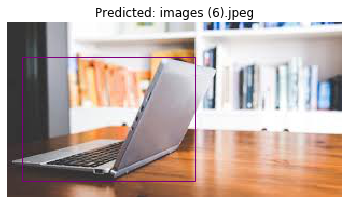

router [   8  440  864 1432] 0.99877936


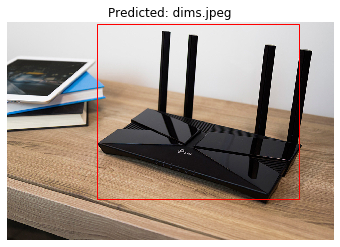

router [ 48   1 165 167] 0.9981688


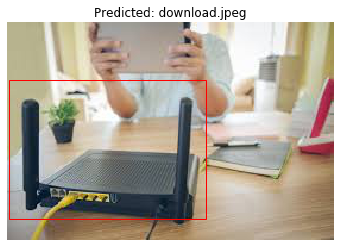

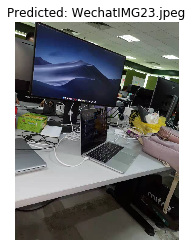

tv [ 32  93 103 182] 0.99713826
router [  5 187  33 229] 0.92004544


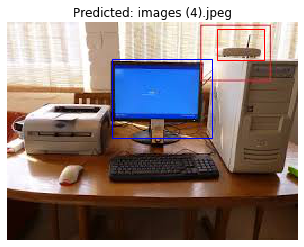

ceiling fan [  0  84  36 169] 0.99235606


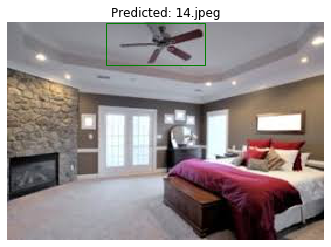

router [ 24  29 225 225] 0.96294624


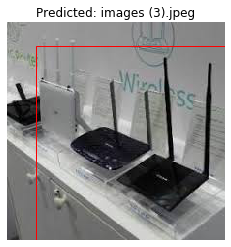

ceiling fan [ 22  79 167 292] 0.9952042


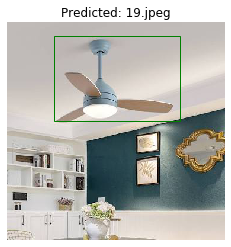

laptop [ 36  80 146 244] 0.99940264
laptop [ 85  64 130 117] 0.8625816


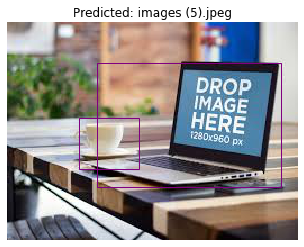

ceiling fan [ 12 120  42 183] 0.99652463


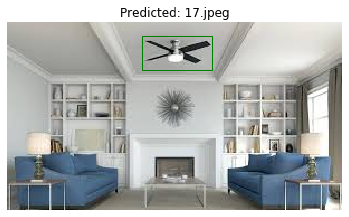

router [ 46  23 170 177] 0.9997917


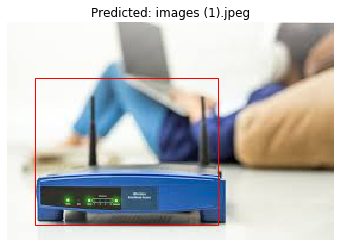

laptop [  8  66  98 211] 0.9552143
router [  0  48  93 201] 0.779058


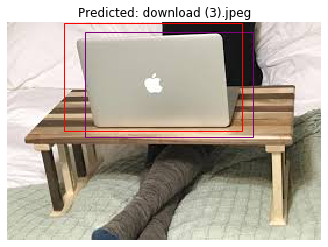

laptop [ 172  237  907 1173] 0.8911083
tv [100 223 597 972] 0.81563675


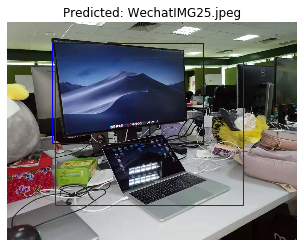

ceiling fan [ 12  58  78 176] 0.9505903


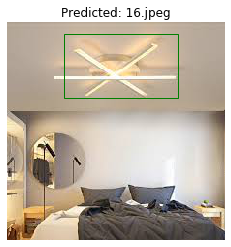

laptop [ 57  37 155 187] 0.981043


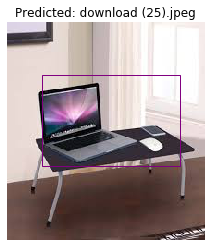

ceiling fan [  1  50  54 169] 0.9895551


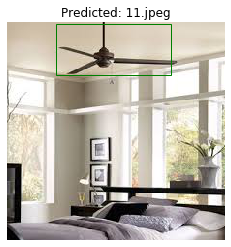

ceiling fan [  2  52  41 143] 0.98973644


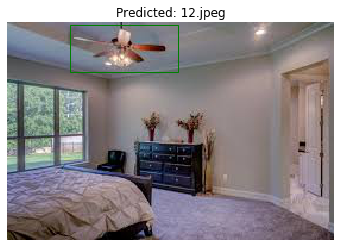

laptop [ 23  28 140 228] 0.9978137


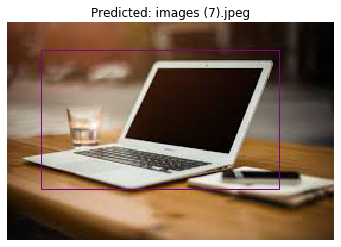

ceiling fan [  5  52  55 138] 0.9944354


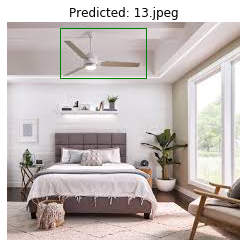

ceiling fan [  1  89  42 175] 0.9993863


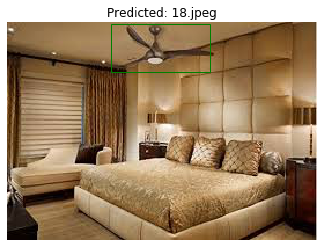

ceiling fan [ 52  56  86 140] 0.99884844
tv [ 97  85 135 136] 0.990672


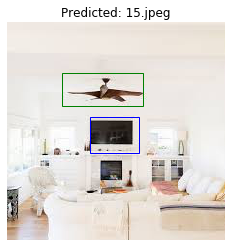

router [ 54  19 137 108] 0.9606939


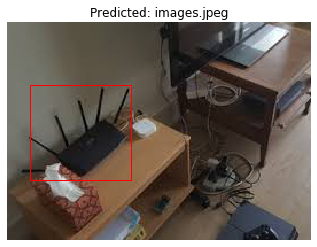

router [ 10  12 259 259] 0.8602671


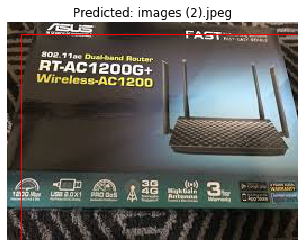

laptop [ 21  34 114 176] 0.9968892


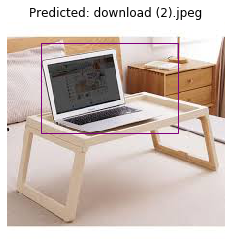

router [  4  66 159 292] 0.9441883


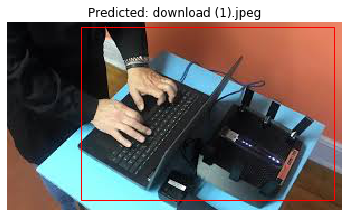

In [14]:
thres = 0.1
color_dict = {'router': 'red', 'ceiling fan': 'green', 'tv': 'blue', 'laptop': 'purple'}


for img_name in image_dictionary.keys():
    image = image_dictionary[img_name]['img']
    pred = image_dictionary[img_name]['pred']
    plt.imshow(image)
    plt.axis('off')
    ax = plt.gca()
    # plot each box
    for box, scr, cls in zip(pred['rois'], pred['scores'], pred['class_ids']):
        if scr > thres:     
            # get coordinates
            y1, x1, y2, x2 = box
            print(cls, box, scr)
            # calculate width and height of the box
            width, height = x2 - x1, y2 - y1
            # create the shape
            rect = Rectangle((x1, y1), width, height, fill=False, color=color_dict[cls])
            # draw the box
            ax.add_patch(rect)
            # plot mask
            #plt.imshow(mask, cmap='gray', alpha=0.3)
    plt.title('Predicted: {}'.format(img_name))
    plt.show()
    #plt.savefig('result.png')
    #plt.close()
    

laptop [ 18  20 144 163] 0.87114316
router [ 46  91 311 311] 0.72406507


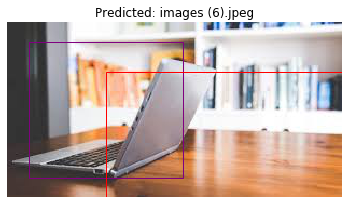

router [   0    0  824 1312] 0.9592585
router [ 248  656  736 1560] 0.740196


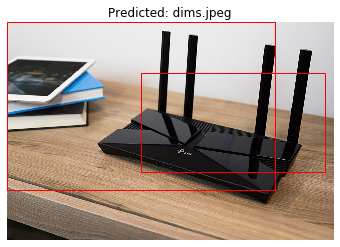

router [ 55   0 140 184] 0.8838594
router [ 97  79 170 242] 0.80157804


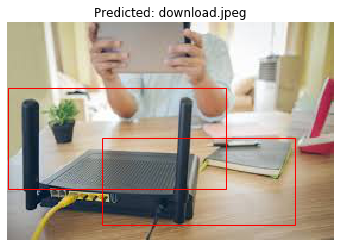

router [ 381  309 1051 1022] 0.8468269
router [ 727    0 1267 1000] 0.7092454


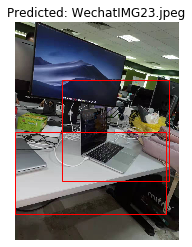

laptop [ 59 112 132 185] 0.8623389
tv [ 40  86  91 180] 0.84841514
router [ 68  11 126 103] 0.8478151


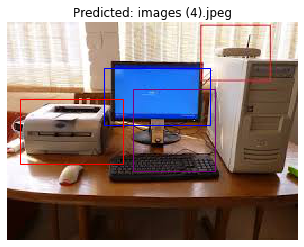

ceiling fan [  0  69  60 249] 0.89424545
tv [ 77 212  98 258] 0.8127044
ceiling fan [  0  81  36 170] 0.75683755


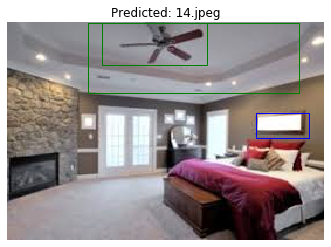

laptop [ 49  57 182 178] 0.92881155
router [ 61   1 114  39] 0.8632636
router [ 77  70 225 225] 0.77528906


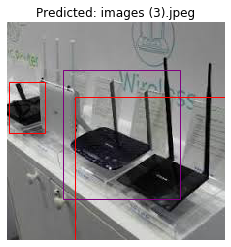

ceiling fan [ 42  38 149 314] 0.90726644
router [290  84 323 123] 0.71241343


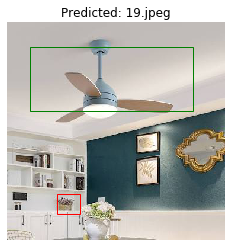

laptop [ 31  80 259 259] 0.9643938
laptop [ 91  59 128 108] 0.73521763


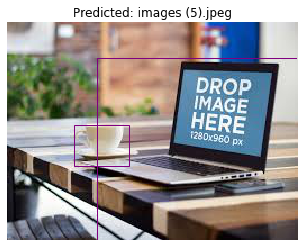

ceiling fan [ 10 114  39 189] 0.8734221


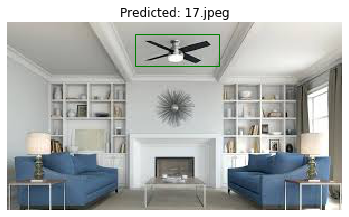

router [ 88  24 167 198] 0.9004653


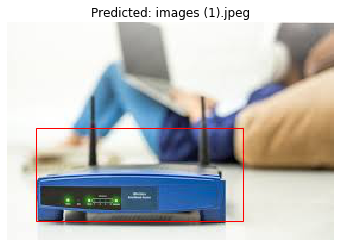

router [ 16  66  87 194] 0.76343775


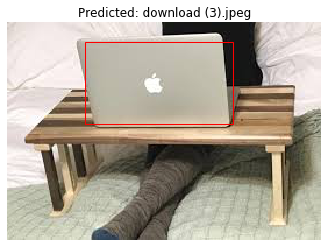

tv [180 259 648 878] 0.82477826
router [ 417 1116 1440 1440] 0.7776381
router [ 597    0 1080  619] 0.72993016


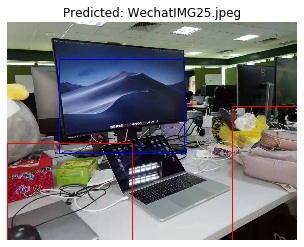

tv [  7   9  95 208] 0.7482466


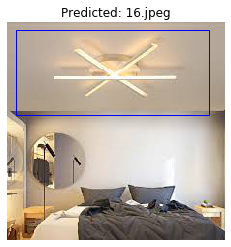

laptop [ 56  43 165 167] 0.8905876
router [ 40   9 179 213] 0.7452895


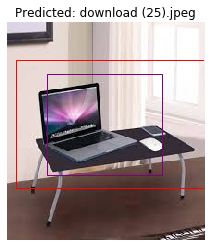

ceiling fan [  3  31  50 174] 0.9023524
ceiling fan [  1  84  36 113] 0.72620726


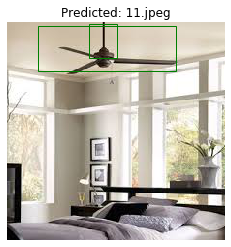

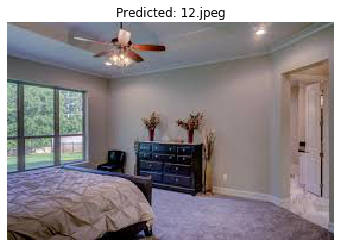

laptop [ 20  53 147 215] 0.93039244
laptop [ 90 169 138 244] 0.7694111
router [ 35   4 143 189] 0.75925815
laptop [  0 159 152 265] 0.7254505


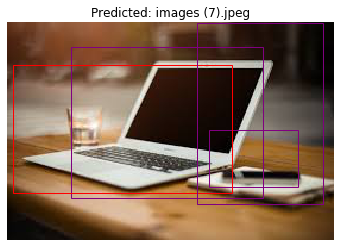

ceiling fan [ 11  37  52 140] 0.85954225
tv [ 55 162 151 231] 0.7854509
router [117  46 211 163] 0.70337003


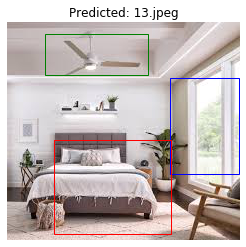

router [104   0 152  83] 0.78111345
router [101  54 124  93] 0.7778747


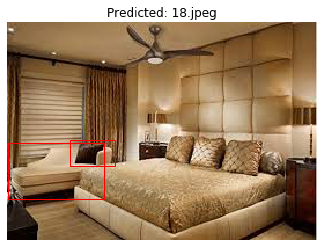

tv [100  86 135 138] 0.9384318
ceiling fan [ 51  49  87 162] 0.81590253
tv [142  95 168 121] 0.7809871
router [147  61 225 225] 0.7319008


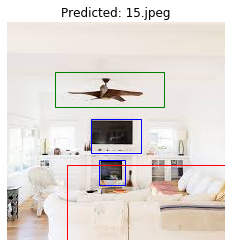

router [ 39  22 161 153] 0.8958594
router [ 56  39 127 103] 0.7132616


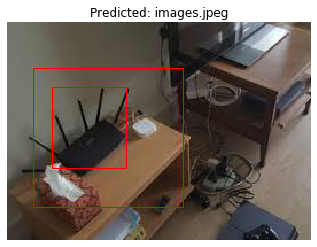

ceiling fan [  6 157  24 225] 0.7785225
laptop [  2  95 132 246] 0.7328325


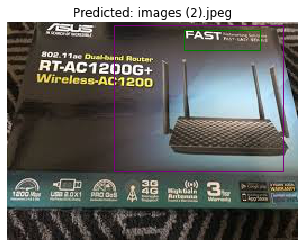

laptop [ 19  45 115 180] 0.8675382
router [  0   0 156  43] 0.7806093
router [ 34   0 205 200] 0.74495447


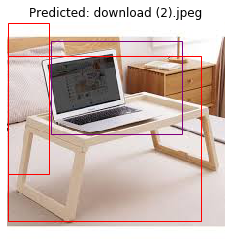

router [ 37  82 300 300] 0.9509291


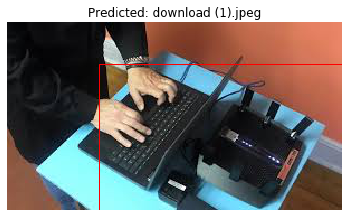

In [10]:
# epoch 1 ==================

thres = 0.1
color_dict = {'router': 'red', 'ceiling fan': 'green', 'tv': 'blue', 'laptop': 'purple'}


for img_name in image_dictionary.keys():
    image = image_dictionary[img_name]['img']
    pred = image_dictionary[img_name]['pred']
    plt.imshow(image)
    plt.axis('off')
    ax = plt.gca()
    # plot each box
    for box, scr, cls in zip(pred['rois'], pred['scores'], pred['class_ids']):
        if scr > thres:     
            # get coordinates
            y1, x1, y2, x2 = box
            print(cls, box, scr)
            # calculate width and height of the box
            width, height = x2 - x1, y2 - y1
            # create the shape
            rect = Rectangle((x1, y1), width, height, fill=False, color=color_dict[cls])
            # draw the box
            ax.add_patch(rect)
            # plot mask
            #plt.imshow(mask, cmap='gray', alpha=0.3)
    plt.title('Predicted: {}'.format(img_name))
    plt.show()
    #plt.savefig('result.png')
    #plt.close()
    